In [34]:

import sys
import numpy as np
from mynn import *
from mydata import *
from datetime import datetime

import matplotlib as mpl 
from matplotlib.lines import Line2D 
# mpl.use('TkAgg')
import matplotlib.pyplot as plt

# plt.rc("figure", dpi=300)           # High-quality figure ("dots-per-inch")
# plt.rc("text", usetex=True)         # Crisp axis ticks
# plt.rc("font", family="serif")      # Crisp axis labels
# plt.rc("legend", edgecolor='none')  # No boxes around legends

# plt.rc("figure",facecolor="#ffffff")
# plt.rc("axes",facecolor="#ffffff",edgecolor="#000000",labelcolor="#000000")
# plt.rc("savefig",facecolor="#ffffff")
# plt.rc("text",color="#000000")
# plt.rc("xtick",color="#000000")
# plt.rc("ytick",color="#000000")

color1 = 'tab:blue'
color2 = 'tab:green'
color3 = 'tab:orange'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [35]:

#M_  = [312*(2**i) for i in range(6)]
#N_neurons = [16,64,128,256]
test_error_mean = dict()
for nneurons in [16]:
    test_error_mean["ParaNet"] = []
    for M in [312, 624, 1248, 2496]:
        
        N = 100
        ntrain = M//2

        inputs = np.load("../../../../data/Helmholtz_inputs.npy")   
        outputs = np.load("../../../../data/Helmholtz_outputs.npy")  

        K_test = outputs[:, :, M//2:M]
        acc = 0.99

        xgrid = np.linspace(0,1,N+1)
        dx    = xgrid[1] - xgrid[0]

        train_inputs = np.reshape(inputs[:,:,:M//2], (-1, M//2))
        test_inputs  = np.reshape(inputs[:,:,M//2:M], (-1, M-M//2))
        Ui,Si,Vi = np.linalg.svd(train_inputs)
        en_f= 1 - np.cumsum(Si)/np.sum(Si)
        r_f = np.argwhere(en_f<(1-acc))[0,0]

        r_f = min(r_f, 512)

        Uf = Ui[:,:r_f]
        f_hat = np.matmul(Uf.T,train_inputs)
        f_hat_test = np.matmul(Uf.T,test_inputs)
        x_train_part = f_hat.T.astype(np.float32)
        x_test_part = f_hat_test.T.astype(np.float32)

        del inputs
        del Ui, Vi, Uf,f_hat

        ########### Test
        Y, X = np.meshgrid(xgrid, xgrid)
        # test
        i = 20
        j = 40
        assert(X[i, j] == i*dx and Y[i, j] == j*dx)

        X_upper = np.reshape(X, -1)
        Y_upper = np.reshape(Y, -1)
        N_upper = len(X_upper)
        x_train = np.zeros((M//2 * N_upper, r_f + 2), dtype = np.float32)
        y_train = np.zeros(M//2 * N_upper, dtype = np.float32)

        for i in range(M//2):
            d_range = range(i*N_upper, (i + 1)*N_upper)
            x_train[d_range , 0:r_f]   = x_train_part[i, :]
            x_train[d_range , r_f]     = X_upper
            x_train[d_range , r_f + 1] = Y_upper 
            y_train[d_range] = np.reshape(outputs[:, :, i], -1)


        x_train = torch.from_numpy(x_train)
        y_train = torch.from_numpy(y_train).unsqueeze(-1)

        x_normalizer = UnitGaussianNormalizer(x_train)
        x_normalizer.encode_(x_train)


        x_test = np.zeros(((M-M//2) * N_upper, r_f + 2), dtype = np.float32)
        for i in range(M-M//2):
            d_range = range(i*N_upper, (i + 1)*N_upper)
            x_test[d_range , 0:r_f]   = x_test_part[i, :]
            x_test[d_range , r_f]     = X_upper
            x_test[d_range , r_f + 1] = Y_upper 

        # x_normalizer.cpu()
        x_test = torch.from_numpy(x_test)
        x_normalizer.encode_(x_test)
        y_normalizer = UnitGaussianNormalizer(y_train)



        model = torch.load("../../../../data/Models/ParaNet"+str(nneurons)+"Nd_"+str(ntrain)+".model", map_location=device)
        model.to(device)


        rel_err_nn_test = np.zeros(M//2)
        for i in range(M-M//2):
            print("i / N = ", i, " / ", M-M//2)
            K_test_pred_upper = y_normalizer.decode(model(x_test[i*N_upper:(i+1)*N_upper, :].to(device)).detach()).cpu().numpy()
            K_test_pred = np.reshape(K_test_pred_upper, (N+1,N+1))
            #rel_err_nn_test[i] =  np.linalg.norm(K_test_pred - K_test[:, :, i])/np.linalg.norm(K_test[:, :, i])
            rel_err_nn_test[i] =  np.linalg.norm(K_test_pred - K_test[:, :, i])
        mre_nn_test = np.mean(rel_err_nn_test)

        test_error_mean["ParaNet"].append(mre_nn_test)

i / N =  0  /  156
i / N =  1  /  156
i / N =  2  /  156
i / N =  3  /  156
i / N =  4  /  156
i / N =  5  /  156
i / N =  6  /  156
i / N =  7  /  156
i / N =  8  /  156
i / N =  9  /  156
i / N =  10  /  156
i / N =  11  /  156
i / N =  12  /  156
i / N =  13  /  156
i / N =  14  /  156
i / N =  15  /  156
i / N =  16  /  156
i / N =  17  /  156
i / N =  18  /  156
i / N =  19  /  156
i / N =  20  /  156
i / N =  21  /  156
i / N =  22  /  156
i / N =  23  /  156
i / N =  24  /  156
i / N =  25  /  156
i / N =  26  /  156
i / N =  27  /  156
i / N =  28  /  156
i / N =  29  /  156
i / N =  30  /  156
i / N =  31  /  156
i / N =  32  /  156
i / N =  33  /  156
i / N =  34  /  156
i / N =  35  /  156
i / N =  36  /  156
i / N =  37  /  156
i / N =  38  /  156
i / N =  39  /  156
i / N =  40  /  156
i / N =  41  /  156
i / N =  42  /  156
i / N =  43  /  156
i / N =  44  /  156
i / N =  45  /  156
i / N =  46  /  156
i / N =  47  /  156
i / N =  48  /  156
i / N =  49  /  156
i / N =  5

In [39]:
K_test_pred_upper = y_normalizer.decode(model(x_test[0:N_upper, :].to(device)).detach()).cpu().numpy()
K_test_pred = np.reshape(K_test_pred_upper, (N+1,N+1))

(Text(0.5, 0, 'x'), Text(0.5, 1.0, 'u(x,y)_truth'))

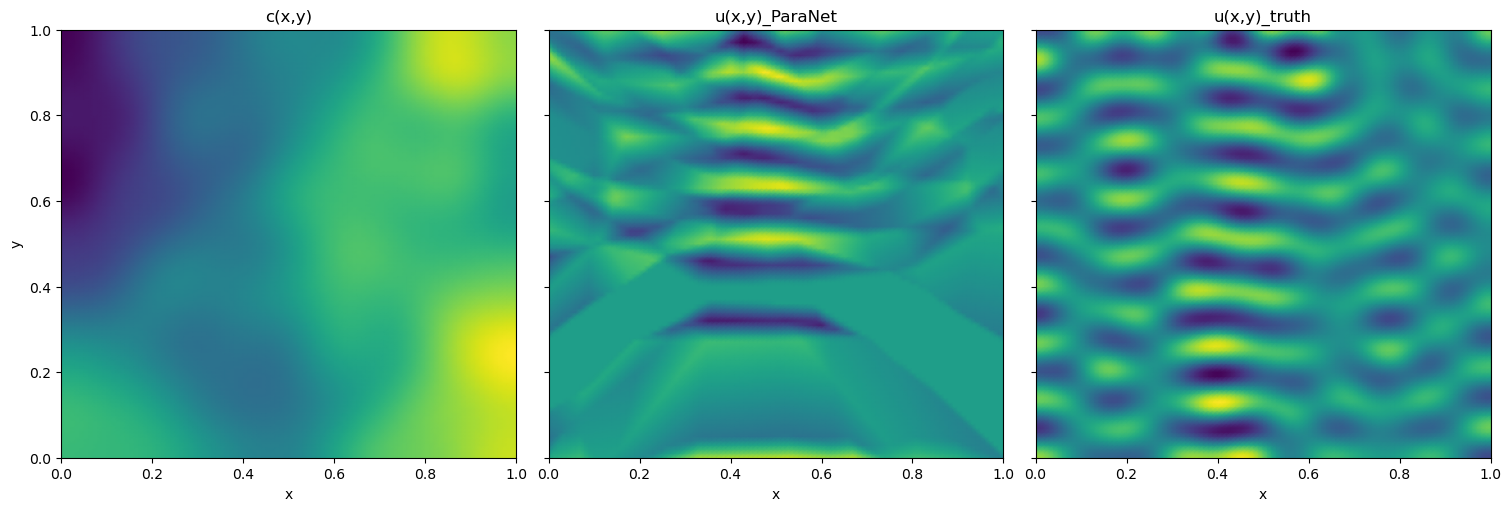

In [42]:
xgrid = np.linspace(0,1,N+1)
Y, X = np.meshgrid(xgrid, xgrid)

inputs = np.load("../../../../data/Helmholtz_inputs.npy")   
outputs = np.load("../../../../data/Helmholtz_outputs.npy")  

_, axs = plt.subplots(1, 3,figsize = (15,5), layout='constrained', sharey=True)
axs[0].pcolormesh(X, Y, inputs[:, :,M//2], shading="gouraud")
axs[0].set_xlabel("x"), axs[0].set_ylabel("y"), axs[0].set_title("c(x,y)")


axs[1].pcolormesh(X, Y, K_test_pred, shading="gouraud")
axs[1].set_xlabel("x"), axs[1].set_title("u(x,y)_ParaNet")

axs[2].pcolormesh(X, Y, outputs[:, :,M//2], shading="gouraud")
axs[2].set_xlabel("x"), axs[2].set_title("u(x,y)_truth")

In [43]:

N_neurons = [16]
for nneurons in N_neurons:
    test_error_mean["DeepOnet"] = []
    for M in [312, 624, 1248, 2496]:
        
        N = 100
        ntrain = M//2

        inputs = np.load("../../../../data/Helmholtz_inputs.npy")   
        outputs = np.load("../../../../data/Helmholtz_outputs.npy")  

        K_test = outputs[:, :, M//2:M]
        acc = 0.99

        xgrid = np.linspace(0,1,N+1)
        dx    = xgrid[1] - xgrid[0]

        train_inputs = np.reshape(inputs[:,:,:M//2], (-1, M//2))
        test_inputs  = np.reshape(inputs[:,:,M//2:M], (-1, M-M//2))
        Ui,Si,Vi = np.linalg.svd(train_inputs)
        en_f= 1 - np.cumsum(Si)/np.sum(Si)
        r_f = np.argwhere(en_f<(1-acc))[0,0]

        r_f = min(r_f, 512)

        Uf = Ui[:,:r_f]
        f_hat = np.matmul(Uf.T,train_inputs)
        f_hat_test = np.matmul(Uf.T,test_inputs)
        x_train_part = f_hat.T.astype(np.float32)
        x_test_part = f_hat_test.T.astype(np.float32)

        del inputs
        del Ui, Vi, Uf,f_hat

        ########### Test
        Y, X = np.meshgrid(xgrid, xgrid)
        # test
        i = 20
        j = 40
        assert(X[i, j] == i*dx and Y[i, j] == j*dx)

        X_upper = full2upper(X)
        Y_upper = full2upper(Y)
        N_upper = len(X_upper)
        x_train = np.zeros((M//2 * N_upper, r_f + 2), dtype = np.float32)
        y_train = np.zeros(M//2 * N_upper, dtype = np.float32)

        for i in range(M//2):
            d_range = range(i*N_upper, (i + 1)*N_upper)
            x_train[d_range , 0:r_f]   = x_train_part[i, :]
            x_train[d_range , r_f]     = X_upper
            x_train[d_range , r_f + 1] = Y_upper 
            y_train[d_range] = full2upper(outputs[:, :, i])


        x_train = torch.from_numpy(x_train)
        y_train = torch.from_numpy(y_train).unsqueeze(-1)

        x_normalizer = UnitGaussianNormalizer(x_train)
        x_normalizer.encode_(x_train)


        x_test = np.zeros(((M-M//2) * N_upper, r_f + 2), dtype = np.float32)
        for i in range(M-M//2):
            d_range = range(i*N_upper, (i + 1)*N_upper)
            x_test[d_range , 0:r_f]   = x_test_part[i, :]
            x_test[d_range , r_f]     = X_upper
            x_test[d_range , r_f + 1] = Y_upper 

        # x_normalizer.cpu()
        x_test = torch.from_numpy(x_test)
        x_normalizer.encode_(x_test)
        y_normalizer = UnitGaussianNormalizer(y_train)

        model = torch.load("../../../../data/Models/DeepONetNet_"+str(nneurons)+"Nd_"+str(ntrain)+".model", map_location=device)
        model.to(device)


        rel_err_nn_test = np.zeros(M//2)
        for i in range(M-M//2):
            print("i / N = ", i, " / ", M-M//2)
            K_test_pred_upper = y_normalizer.decode(model(x_test[i*N_upper:(i+1)*N_upper, :].to(device)).detach()).cpu().numpy()
            K_test_pred = upper2full_1(K_test_pred_upper)
            #rel_err_nn_test[i] =  np.linalg.norm(K_test_pred - K_test[:, :, i])/np.linalg.norm(K_test[:, :, i])
            rel_err_nn_test[i] =  np.linalg.norm(K_test_pred - K_test[:, :, i])
        mre_nn_test = np.mean(rel_err_nn_test)

        test_error_mean["DeepOnet"].append(mre_nn_test)

i / N =  0  /  156
i / N =  1  /  156
i / N =  2  /  156
i / N =  3  /  156
i / N =  4  /  156
i / N =  5  /  156
i / N =  6  /  156
i / N =  7  /  156
i / N =  8  /  156
i / N =  9  /  156
i / N =  10  /  156
i / N =  11  /  156
i / N =  12  /  156
i / N =  13  /  156
i / N =  14  /  156
i / N =  15  /  156
i / N =  16  /  156
i / N =  17  /  156
i / N =  18  /  156
i / N =  19  /  156
i / N =  20  /  156
i / N =  21  /  156
i / N =  22  /  156
i / N =  23  /  156
i / N =  24  /  156
i / N =  25  /  156
i / N =  26  /  156
i / N =  27  /  156
i / N =  28  /  156
i / N =  29  /  156
i / N =  30  /  156
i / N =  31  /  156
i / N =  32  /  156
i / N =  33  /  156
i / N =  34  /  156
i / N =  35  /  156
i / N =  36  /  156
i / N =  37  /  156
i / N =  38  /  156
i / N =  39  /  156
i / N =  40  /  156
i / N =  41  /  156
i / N =  42  /  156
i / N =  43  /  156
i / N =  44  /  156
i / N =  45  /  156
i / N =  46  /  156
i / N =  47  /  156
i / N =  48  /  156
i / N =  49  /  156
i / N =  5

In [44]:
K_test_pred_upper = y_normalizer.decode(model(x_test[0:1*N_upper, :].to(device)).detach()).cpu().numpy()
K_test_pred = upper2full_1(K_test_pred_upper)

(Text(0.5, 0, 'x'), Text(0.5, 1.0, 'u(x,y)_truth'))

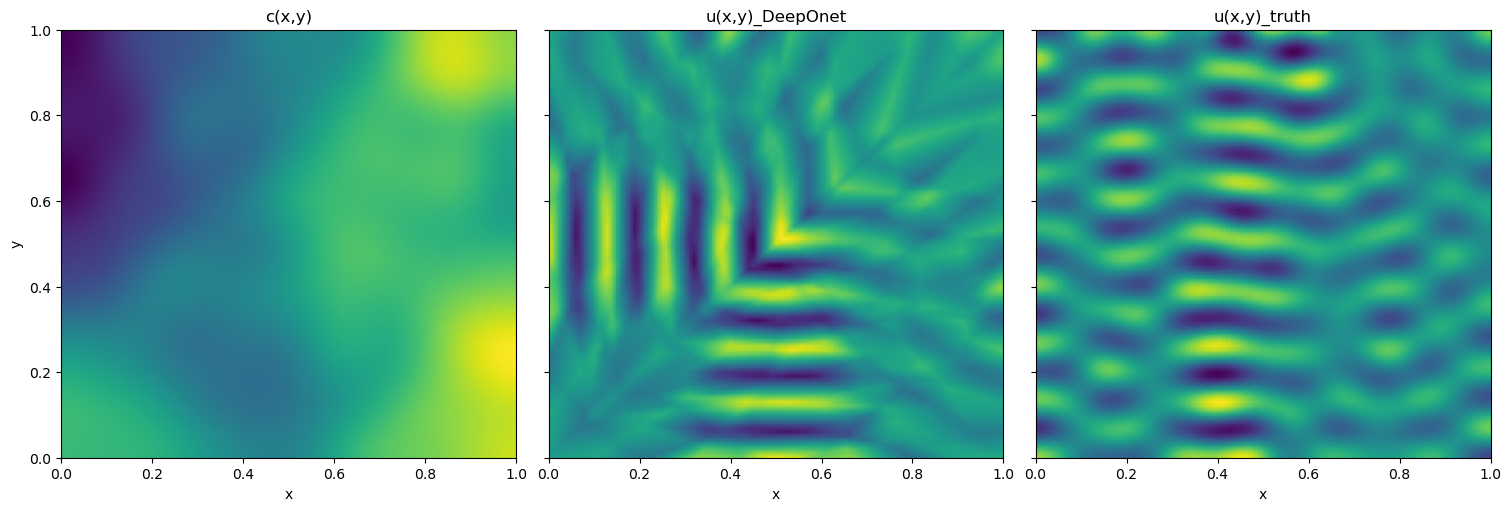

In [46]:
xgrid = np.linspace(0,1,N+1)
Y, X = np.meshgrid(xgrid, xgrid)

inputs = np.load("../../../../data/Helmholtz_inputs.npy")   
outputs = np.load("../../../../data/Helmholtz_outputs.npy")  

_, axs = plt.subplots(1, 3,figsize = (15,5), layout='constrained', sharey=True)
axs[0].pcolormesh(X, Y, inputs[:, :,M//2], shading="gouraud")
axs[0].set_xlabel("x"), axs[0].set_ylabel("y"), axs[0].set_title("c(x,y)")


axs[1].pcolormesh(X, Y, K_test_pred, shading="gouraud")
axs[1].set_xlabel("x"), axs[1].set_title("u(x,y)_DeepOnet")

axs[2].pcolormesh(X, Y, K_test[:, :, 0], shading="gouraud")
axs[2].set_xlabel("x"), axs[2].set_title("u(x,y)_truth")

In [47]:

N_neurons = [16]
for nneurons in N_neurons:
    test_error_mean["FNO"] = []
    for M in [312, 624, 1248, 2496]:
        
        N = 100
        ntrain = M//2
        ntest = M-M//2
        s = N+1

        inputs = np.load("../../../../data/Helmholtz_inputs.npy")   
        outputs = np.load("../../../../data/Helmholtz_outputs.npy")  

        ########### Test
        xgrid = np.linspace(0,1,N+1)
        dx    = xgrid[1] - xgrid[0]
        Y, X = np.meshgrid(xgrid, xgrid)

       

        inputs = inputs.transpose(2, 0, 1)
        outputs = outputs.transpose(2, 0, 1)

        x_train = torch.from_numpy(np.reshape(inputs[:M//2, :, :], -1).astype(np.float32))
        y_train = torch.from_numpy(np.reshape(outputs[:M//2, :, :], -1).astype(np.float32))

        x_test = torch.from_numpy(np.reshape(inputs[M//2:M, :, :], -1).astype(np.float32))
        y_test = torch.from_numpy(np.reshape(outputs[M//2:M, :, :], -1).astype(np.float32))


        x_normalizer = UnitGaussianNormalizer(x_train)
        x_train = x_normalizer.encode(x_train)
        x_test = x_normalizer.encode(x_test)

        y_normalizer = UnitGaussianNormalizer(y_train)
        y_train = y_normalizer.encode(y_train)

        x_train = x_train.reshape(ntrain,s,s,1)
        x_test = x_test.reshape(ntest,s,s,1)

        # todo do we need this
        y_train = y_train.reshape(ntrain,s,s,1)
        y_test = y_test.reshape(ntest,s,s,1)


        model = torch.load("../../../../data/Models/FNO_"+str(nneurons)+"Nd_"+str(ntrain)+".model", map_location=device)
        model.to(device)


        rel_err_nn_test = np.zeros(M-M//2)
        for i in range(M-M//2):
            print("i / N = ", i, " / ", M-M//2)
            K_test = y_normalizer.decode(model(x_test[i:i+1, :, :, :].to(device))).detach().cpu().numpy()
            #rel_err_nn_test[i] =  np.linalg.norm(K_test - y_test[i, :, :].cpu().numpy())/np.linalg.norm(y_test[i, :, :].cpu().numpy())
            rel_err_nn_test[i] =  np.linalg.norm(K_test - y_test[i, :, :].cpu().numpy())
        mre_nn_test = np.mean(rel_err_nn_test)

        test_error_mean["FNO"].append(mre_nn_test)

i / N =  0  /  156
i / N =  1  /  156
i / N =  2  /  156
i / N =  3  /  156
i / N =  4  /  156
i / N =  5  /  156
i / N =  6  /  156
i / N =  7  /  156
i / N =  8  /  156
i / N =  9  /  156
i / N =  10  /  156
i / N =  11  /  156
i / N =  12  /  156
i / N =  13  /  156
i / N =  14  /  156
i / N =  15  /  156
i / N =  16  /  156
i / N =  17  /  156
i / N =  18  /  156
i / N =  19  /  156
i / N =  20  /  156
i / N =  21  /  156
i / N =  22  /  156
i / N =  23  /  156
i / N =  24  /  156
i / N =  25  /  156
i / N =  26  /  156
i / N =  27  /  156
i / N =  28  /  156
i / N =  29  /  156
i / N =  30  /  156
i / N =  31  /  156
i / N =  32  /  156
i / N =  33  /  156
i / N =  34  /  156
i / N =  35  /  156
i / N =  36  /  156
i / N =  37  /  156
i / N =  38  /  156
i / N =  39  /  156
i / N =  40  /  156
i / N =  41  /  156
i / N =  42  /  156
i / N =  43  /  156
i / N =  44  /  156
i / N =  45  /  156
i / N =  46  /  156
i / N =  47  /  156
i / N =  48  /  156
i / N =  49  /  156
i / N =  5

In [51]:
K_test = y_normalizer.decode(model(x_test[0:1, :, :, :].to(device))).detach().cpu().numpy()
K_test.shape

(1, 101, 101, 1)

(Text(0.5, 0, 'x'), Text(0.5, 1.0, 'u(x,y)_truth'))

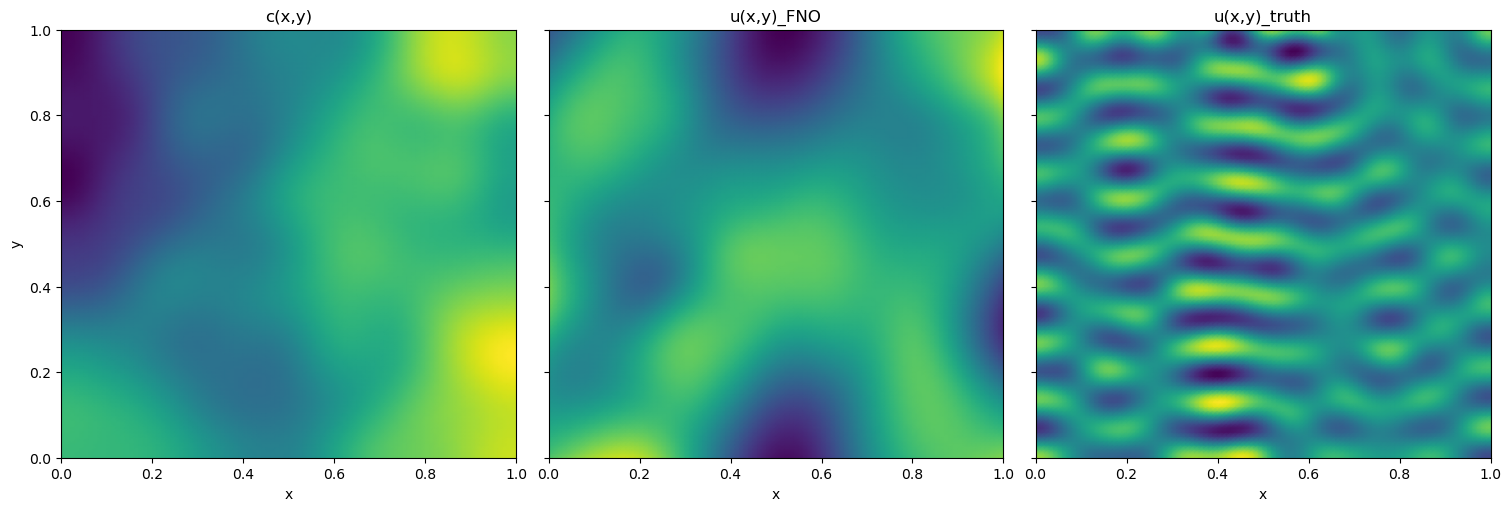

In [54]:
xgrid = np.linspace(0,1,N+1)
Y, X = np.meshgrid(xgrid, xgrid)

inputs = np.load("../../../../data/Helmholtz_inputs.npy")   

_, axs = plt.subplots(1, 3,figsize = (15,5), layout='constrained', sharey=True)
axs[0].pcolormesh(X, Y, x_test[0,:,:,0], shading="gouraud")
axs[0].set_xlabel("x"), axs[0].set_ylabel("y"), axs[0].set_title("c(x,y)")


axs[1].pcolormesh(X, Y, K_test[0,:,:,0], shading="gouraud")
axs[1].set_xlabel("x"), axs[1].set_title("u(x,y)_FNO")

axs[2].pcolormesh(X, Y, y_test[0,:, :,0], shading="gouraud")
axs[2].set_xlabel("x"), axs[2].set_title("u(x,y)_truth")

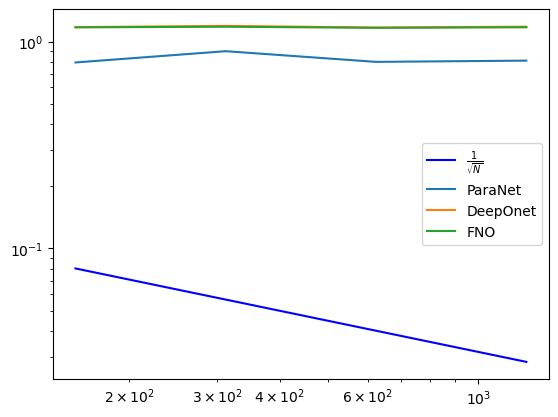

In [68]:
d = np.array([156, 312, 624,1248])

plt.loglog(d, 1/np.sqrt(d),color = "blue", label= r"$\frac{1}{\sqrt{N}}$")

for key in test_error_mean.keys():
    plt.loglog(d,np.array(test_error_mean[str(key)]),label = key)

plt.legend()

In [9]:
test_error_mean

{'ParaNet': [0.7922583121232202,
  0.8981767600946142,
  0.7974494663482821,
  0.808757951220232],
 'DeepOnet': [1.1742326729892063,
  1.1904062957093156,
  1.1687540320469456,
  1.180153316936906],
 'FNO': [1.1709464028095589,
  1.1792076873855712,
  1.1649092137813568,
  1.1719939281734137]}